# this notebook coarsely estimate RR

In [1]:
import numpy as np
import argparse

import os
import math
from math import sin

import json

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary
torch.manual_seed(0)

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from plotting_tools import *
from setting import *
from models import *
from models_CNN import *
from evaluate import *
from preprocessing import *

from stage3_preprocess import *
from training_util import *
from dataset_util import *
from dataIO import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
print(torch.version.cuda)

11.3


In [3]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage3/', 
                          '--output_folder', '../../data/stage4/RR_est/',
                          '--training_params_file', 'training_params_baseline.json',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage3/', output_folder='../../data/stage4/RR_est/', training_params_file='training_params_baseline.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
training_params_file = args.training_params_file

if not os.path.exists(outputdir):
    os.makedirs(outputdir)

    

# get training params and dataloaders

In [5]:
torch.cuda.is_available()

True

In [6]:
with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)

for training_params in [training_params_list[0]]:
    # include device in training_params
#     device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
#     training_params['device'] = device


    training_params['CV_config'] = {
        'subject_id': 113,
        'task_id': 1,
    }
    stage3_dict = data_loader('stage3_dict', inputdir).item()
    
    training_params = merge_dict(training_params, stage3_dict)
#     training_params['list_signal'] = stage3_dict['list_signal']
#     training_params['list_feature'] = stage3_dict['list_feature']
#     training_params['list_output'] = stage3_dict['list_output']
#     training_params['list_meta'] = stage3_dict['list_meta']
#     training_params['FS_RESAMPLE_DL'] = stage3_dict['FS_RESAMPLE_DL']
#     training_params['subject_ids'] = stage3_dict['subject_ids']
#     training_params['task_ids'] = stage3_dict['task_ids']
    
#     input_CV = '../../data/stage3/113/CV2/'
#     dataloaders, dataset_sizes = get_loaders(input_CV, training_params)
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)
    print('data dimensions are:', dataloaders['train'].dataset.data.shape)

    data_dimensions = dataloaders['train'].dataset.__getitem__(0)[0].size()
    training_params['data_dimensions'] = list(data_dimensions)
    
    sweep_name = training_params['sweep_name'] 
    

# training_params = training_params_list[0]

data dimensions are: (4865, 3, 3000)


In [7]:
training_params

{'model_name': 'cnn',
 'sweep_name': 'baseline',
 'kernel_size': [10],
 'channel_n': 16,
 'num_epochs': 3,
 'batch_size': 64,
 'learning_rate': 0.001,
 'cuda_i': 0,
 'use_sc': True,
 'wandb': True,
 'input_names': ['ECG', 'accelZ', 'ppg_r_1'],
 'feature_names': ['HR_patch', 'weight'],
 'output_names': ['RR_cosmed'],
 'meta_names': ['subject_id', 'task'],
 'CV_config': {'subject_id': 113, 'task_id': 1},
 'list_feature': ['VE_cosmed', 'HR_patch', 'weight'],
 'list_output': ['RR_cosmed',
  'VT_cosmed',
  'EE_cosmed',
  'SPO2_cosmed',
  'HR_cosmed',
  'VO2_cosmed',
  'resp_cosmed'],
 'list_meta': ['subject_id', 'task'],
 'list_signal': ['ECG', 'accelZ', 'ppg_r_1'],
 'FS_RESAMPLE_DL': 100,
 'subject_ids': array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
        115, 116, 117, 118]),
 'task_ids': array([0, 1, 2, 3, 4, 5]),
 'window_size': 30,
 'overlap': 0.9,
 'data_dimensions': [3, 3000]}

In [8]:
dataloaders['train'].dataset.data.shape

(4865, 3, 3000)

In [9]:

from scipy.io import loadmat
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [10]:
def get_RR_range():
    
#     return np.asarray(label_range_dict['br'])/60

#     return np.asarray([0.08, 0.7])
    return np.asarray([0.1, 0.7])


# TBD, this is not as good as signal.stft
def get_psd(sig, NFFT):
    yf = scipy.fftpack.fft(sig)
    yf_scaled = 2.0/NFFT * (np.abs(yf[:NFFT//2])**2)
    return yf_scaled

def get_PSD_windows_scipy(t_sig, sig, Fs, NFFT, noverlap):
    # already tested, this is equivalent to ax.specgram
    # usage:
    # ts_Pxx, Pxx, freq = get_PSD_windows_scipy(t_sig, sig, Fs, NFFT, noverlap)

    freq, t, Zxx = signal.stft(sig, Fs, noverlap=noverlap, nperseg=NFFT, padded=False, boundary=None)
    Pxx = np.abs(Zxx)**2
    ts_Pxx = t + t_sig[0]

    
#     mask = (freq>0.08) & (freq<0.8)
#     freq = freq[mask] # RR can be as low as 0.08 Hz = 4.8 bpm and as high as 0.8 Hz = 48 bpm 
#     RR_range = np.asarray(label_range_dict['br'])/60
    RR_range = get_RR_range()
    
    
    mask = (freq>RR_range[0]) & (freq<RR_range[-1])
    freq = freq[mask]
    
    Pxx = Pxx[mask,:]
    Pxx = Pxx.T
    return ts_Pxx, Pxx, freq


In [11]:
training_params

{'model_name': 'cnn',
 'sweep_name': 'baseline',
 'kernel_size': [10],
 'channel_n': 16,
 'num_epochs': 3,
 'batch_size': 64,
 'learning_rate': 0.001,
 'cuda_i': 0,
 'use_sc': True,
 'wandb': True,
 'input_names': ['ECG', 'accelZ', 'ppg_r_1'],
 'feature_names': ['HR_patch', 'weight'],
 'output_names': ['RR_cosmed'],
 'meta_names': ['subject_id', 'task'],
 'CV_config': {'subject_id': 113, 'task_id': 1},
 'list_feature': ['VE_cosmed', 'HR_patch', 'weight'],
 'list_output': ['RR_cosmed',
  'VT_cosmed',
  'EE_cosmed',
  'SPO2_cosmed',
  'HR_cosmed',
  'VO2_cosmed',
  'resp_cosmed'],
 'list_meta': ['subject_id', 'task'],
 'list_signal': ['ECG', 'accelZ', 'ppg_r_1'],
 'FS_RESAMPLE_DL': 100,
 'subject_ids': array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
        115, 116, 117, 118]),
 'task_ids': array([0, 1, 2, 3, 4, 5]),
 'window_size': 30,
 'overlap': 0.9,
 'data_dimensions': [3, 3000]}

In [12]:
dataloaders['train'].dataset.label.shape

(4865, 1)

In [14]:
# plt.plot(t_sig, sig)

In [15]:
# Fs
# freq, t, Zxx  = signal.stft(sig, Fs)
def get_PSD_scipy(sig, Fs):
    
    N = sig.shape[0]
    T = 1/Fs

    Zxx = scipy.fftpack.fft(sig)[:N//2]
    Pxx = np.abs(Zxx)**2

    freq = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

    
    RR_range = get_RR_range()
    
    mask = (freq>RR_range[0]) & (freq<RR_range[-1])
    freq = freq[mask]
 
    Pxx = Pxx[mask]
    
    return freq, Pxx
# data_FT.append({'freq':xf, 'magnitude': yf})


# plt.plot()

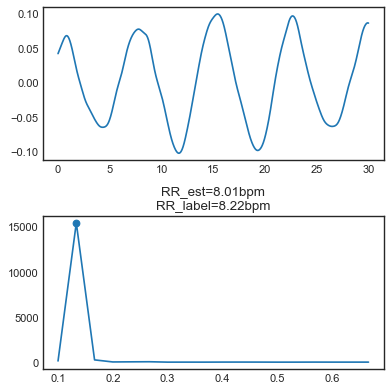

In [18]:
j = 1
sig = dataloaders['val'].dataset.data[j, -1, :]
RR_label = dataloaders['val'].dataset.label[j].squeeze()

Fs = training_params['FS_RESAMPLE_DL']

freq, Pxx = get_PSD_scipy(sig, Fs)

# plt.plot(freq[:10], Pxx[:10])

i_max = np.argmax(Pxx.squeeze())


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5), dpi=80)

t_sig = np.arange(sig.shape[0])/Fs
ax1.plot(t_sig, sig)


RR_est = freq[i_max]*60
ax2.plot(freq, Pxx.squeeze())
ax2.scatter(freq[i_max], Pxx.squeeze()[i_max])
ax2.set_title('RR_est={:.2f}bpm\nRR_label={:.2f}bpm'.format(RR_est, RR_label))

fig.tight_layout()

In [97]:

df_outputlabel_val = pd.DataFrame()

for subject_id in training_params['subject_ids']:
    print(subject_id)
    training_params['CV_config']['subject_id'] = subject_id
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)

    data = dataloaders['val'].dataset.data
    label = dataloaders['val'].dataset.label.squeeze()


    # = label.squeeze()

    for j in range(data.shape[0]):
        sig = data[j, -1, :]

        Fs = training_params['FS_RESAMPLE_DL']

        freq, Pxx = get_PSD_scipy(sig, Fs)

        i_max = np.argmax(Pxx.squeeze())
#         RR_est.append( freq[i_max]*60 )



        df_outputlabel_val = df_outputlabel_val.append(
            pd.DataFrame( {
            'label_est': freq[i_max]*60,
            'label': label[j],
            'CV': subject_id,
            'task': ['RR']
            }), ignore_index=True )


    

101
102
103
104
105
106
107
108
109
110
111
113
114
115
116
117
118


In [100]:
df_outputlabel_val['task'][0]

'RR'

In [ ]:
# TODO: finish this block!

In [ ]:

def get_df_performance2(df_outputlabel):
    
    df_performance = pd.DataFrame()

    
    for subject_id in df_outputlabel['subject_id'].unique()
        df_sub = df_outputlabel[df_outputlabel['subject_id']==subject_id]
        task = df_sub['task'][0]
        
        
        label = df_sub['label']
        label_est = df_sub['label_est']


        rmse = np.sqrt(mean_squared_error(label, label_est))

        mae, _ = get_MAE(label, label_est)
        mape, _ = get_MAPE(label, label_est)

        Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

        df_performance.append(pd.DataFrame({
            'CV': [subject_id],
            'task': [task],
            'Rsquared': [Rsquared],
            'rmse': [rmse],
            'mae': [mae],
            'mape': [mape],
        }), ignore_index=True )

    return df_performance

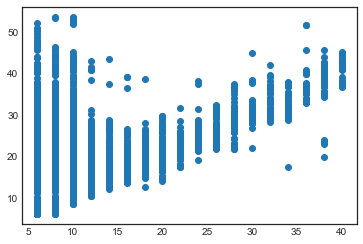

In [98]:
plt.scatter(df_outputlabel_val['label_est'],df_outputlabel_val['label'])

In [ ]:
plot_regression(df_outputlabel_val, df_performance_val, task, show_plot=True, outputdir=None)


In [76]:
# RR_est = []
# RR_label = []
df_outputlabel_val = pd.DataFrame()

# = label.squeeze()

for j in range(data.shape[0]):
    sig = data[j, -1, :]

    Fs = training_params['FS_RESAMPLE_DL']

    freq, Pxx = get_PSD_scipy(sig, Fs)

    i_max = np.argmax(Pxx.squeeze())
    RR_est.append( freq[i_max]*60 )
    
    
    
    df_outputlabel_val = df_outputlabel_val.append(
        pd.DataFrame( {
        'label_est': freq[i_max]*60,
        'label': label[j].squeeze(),
        'CV': subject_id,
        'task': 'RR'
        }), ignore_index=True )


    
RR_est = np.asarray(RR_est)

In [77]:
RR_est.shape, RR_label.shape

((304,), (304,))

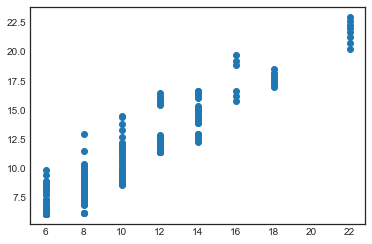

In [78]:
plt.scatter(RR_est, RR_label)

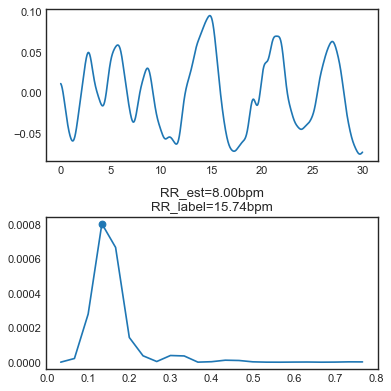

In [27]:
j = 100
sig = dataloaders['train'].dataset.data[j, -1, :]
RR_label = dataloaders['train'].dataset.label[j].squeeze()

Fs = training_params['FS_RESAMPLE_DL']

t_sig = np.arange(sig.shape[0])/Fs
NFFT = int(Fs*training_params['window_size'])  # 20 sec per window
noverlap = int(NFFT*training_params['overlap']) # int(60*0.8*Fs) = 4.8 sec * Fs

ts_Pxx, Pxx, freq = get_PSD_windows_scipy(t_sig, sig, Fs, NFFT, noverlap)

i_max = np.argmax(Pxx.squeeze())


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5), dpi=80)

ax1.plot(t_sig, sig)


RR_est = freq[i_max]*60
ax2.plot(freq, Pxx.squeeze())
ax2.scatter(freq[i_max], Pxx.squeeze()[i_max])
ax2.set_title('RR_est={:.2f}bpm\nRR_label={:.2f}bpm'.format(RR_est, RR_label))

fig.tight_layout()

8.0

# compute MET using our own data

## sedentary MET=1.5 kcal/kg/h = 1.5/60 kcal/kg/min = 0.025 kcal/kg/min
### ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4448542/

In [41]:
# # dataloaders['train'].dataset.data

# i_feature = training_params['feature_names'].index('weight')
# i_label = training_params['output_names'].index('EE_cosmed')


# MET_train = dataloaders['train'].dataset.label[:,i_label] / dataloaders['train'].dataset.feature[:,i_feature]
# MET_train = MET_train.mean()
# print('MET_train is {:.3f} kcal/kg/min'.format(MET_train))

MET_train is 0.039 kcal/kg/min


In [ ]:

def get_df_performance(df_performance, label, label_est, task, subject_id):
    rmse = np.sqrt(mean_squared_error(label, label_est))

    mae, _ = get_MAE(label, label_est)
    mape, _ = get_MAPE(label, label_est)

    Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

    df_performance.append(pd.DataFrame({
        'CV': [subject_id],
        'task': [task],
        'Rsquared': [Rsquared],
        'rmse': [rmse],
        'mae': [mae],
        'mape': [mape],
    }))
    
    return df_performance

In [70]:
task = training_params['output_names'][0]

In [71]:

def get_df_performance(df_performance, label, label_est, task, subject_id):
    rmse = np.sqrt(mean_squared_error(label, label_est))

    mae, _ = get_MAE(label, label_est)
    mape, _ = get_MAPE(label, label_est)

    Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

    df_performance.append(pd.DataFrame({
        'CV': [subject_id],
        'task': [task],
        'Rsquared': [Rsquared],
        'rmse': [rmse],
        'mae': [mae],
        'mape': [mape],
    }))
    
    return df_performance

In [79]:
df_performance_train = []
df_performance_val = []

df_outputlabel_train = []
df_outputlabel_val = []


training_params['feature_names'] = ['weight']
training_params['output_names'] = ['EE_cosmed']

for subject_id in training_params['subject_ids']:

    training_params['CV_config']['subject_id'] = subject_id

    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)
    
    i_feature = training_params['feature_names'].index('weight')
    i_label = training_params['output_names'].index('EE_cosmed')

    MET_train = dataloaders['train'].dataset.label[:,i_label] / dataloaders['train'].dataset.feature[:,i_feature]
    MET_train = MET_train.mean()

    label_est_train = MET_train*dataloaders['train'].dataset.feature[:,i_feature]
    label_train = dataloaders['train'].dataset.label[:,i_label]
    
    label_est_val = MET_train*dataloaders['val'].dataset.feature[:,i_feature]
    label_val = dataloaders['val'].dataset.label[:,i_label]
    
    df_performance_train = get_df_performance(df_performance_train, label_train, label_est_train, task, subject_id)
    df_performance_val = get_df_performance(df_performance_val, label_val, label_est_val, task, subject_id)

        
    df_outputlabel_val.append(
        pd.DataFrame( {
        'label_est': label_est_val,
        'label': label_val,
        'CV': subject_id,
        'MET_train': MET_train
#             'task': [task]*label_val.shape[0]
        })
    )
    # df_outputlabel
    df_outputlabel_train.append(
        pd.DataFrame( {
        'label_est': label_est_train,
        'label': label_train,
        'CV': subject_id,
        'MET_train': MET_train

#             'task': [task]*label_train.shape[0]
        })
    )

df_performance_train = pd.concat(df_performance_train)
df_performance_val = pd.concat(df_performance_val)

df_outputlabel_train = pd.concat(df_outputlabel_train)
df_outputlabel_val = pd.concat(df_outputlabel_val)

input_names are: ['ECG', 'accelZ', 'ppg_r_1']
feature_names are: ['weight']
output_names are: ['EE_cosmed']
meta_names are: ['subject_id', 'task']
(3314, 3, 3000) (3314, 1) (3314, 1) (3314, 2)
input_names are: ['ECG', 'accelZ', 'ppg_r_1']
feature_names are: ['weight']
output_names are: ['EE_cosmed']
meta_names are: ['subject_id', 'task']
(301, 3, 3000) (301, 1) (301, 1) (301, 2)
input_names are: ['ECG', 'accelZ', 'ppg_r_1']
feature_names are: ['weight']
output_names are: ['EE_cosmed']
meta_names are: ['subject_id', 'task']
(3307, 3, 3000) (3307, 1) (3307, 1) (3307, 2)
input_names are: ['ECG', 'accelZ', 'ppg_r_1']
feature_names are: ['weight']
output_names are: ['EE_cosmed']
meta_names are: ['subject_id', 'task']
(308, 3, 3000) (308, 1) (308, 1) (308, 2)
input_names are: ['ECG', 'accelZ', 'ppg_r_1']
feature_names are: ['weight']
output_names are: ['EE_cosmed']
meta_names are: ['subject_id', 'task']
(3306, 3, 3000) (3306, 1) (3306, 1) (3306, 2)
input_names are: ['ECG', 'accelZ', 'ppg_r_1

In [80]:
df_performance_val

,CV,task,Rsquared,rmse,mae,mape
0,101,EE_cosmed,-0.038412,2.172187,1.410192,0.340162
0,102,EE_cosmed,-0.212120,1.307028,1.087031,0.605227
0,103,EE_cosmed,-0.244241,1.430077,1.247168,0.833281
0,104,EE_cosmed,-0.115284,1.799695,1.071593,0.254498
0,106,EE_cosmed,-0.010855,2.085994,1.428131,0.558966
0,107,EE_cosmed,-0.105988,2.067480,1.561854,0.395865
0,110,EE_cosmed,-0.000982,2.776331,2.123248,0.749907
0,111,EE_cosmed,-0.003490,0.776843,0.539899,0.342945
0,113,EE_cosmed,-0.035227,2.594431,2.037503,0.714492
0,114,EE_cosmed,-0.147602,1.585880,1.348472,4.517025


In [52]:
# df_performance_val['rmse'].mean(), df_performance_val['mae'].mean(), df_performance_val['mape'].mean()

In [51]:
# df_performance_val

In [53]:
    
# def plot_regression_partial(ax, subjects_performance_dict, subject_id_plt, training_params,outputdir=None, show_plot=False, log_wandb=False):

#     agg_performance_dict = aggregate_performance_dict(subjects_performance_dict)

#     props = dict(boxstyle='round,pad=0.7', facecolor='white', edgecolor='black', alpha=0.7)
#     fontsize = 16

#     subject_ids = list(subjects_performance_dict.keys())
#     N_beats_val = 0


#     for subject_id in subject_ids:
#         if int(subject_id)//100 == 0:
#             marker = marker_dict['x']
#         elif int(subject_id)//100 == 1:
#             marker = marker_dict['circle']

#         performance_dict = subjects_performance_dict[subject_id]

#         SpO2_val = performance_dict['SpO2_val']
#         SpO2_est_val = performance_dict['SpO2_est_val']


#         color = color_dict[color_names[int(subject_id)%100]]

#         if subject_id == subject_id_plt:
#             alpha=0.6
#             ax.set_title('{}'.format(subject_id), fontsize=fontsize+5)
#             rmse_val = performance_dict['rmse_val']
#         else:
#             alpha=0.03

#         ax.scatter(SpO2_val, SpO2_est_val, alpha=alpha, color=color, marker=marker)

#         N_beats_val += SpO2_val.shape[0]
        
    
#     performance_dict = subjects_performance_dict[subject_id_plt]
# #     print(training_params['use_calibration'], subjects_performance_dict.keys())
#     if training_params['use_calibration']:
#         if 'SpO2_cal_range' in performance_dict:
#             SpO2_cal_range = performance_dict['SpO2_cal_range']
#             subject_id_plt = str(subject_id_plt) + '\n[' + r'$SpO_{2}$' + ' range: {:.1f}-{:.1f}%]'.format(SpO2_cal_range[0], SpO2_cal_range[1])
#     ax_conditioning2(ax, subject_id_plt, fontsize, props, 'RMSE={:.2f}%'.format(rmse_val))
    
    

In [54]:
        
# def ax_conditioning(ax, title_str, fontsize, props, textstr):
#     ax.set_title(title_str, fontsize=fontsize+5)

#     ax.set_ylabel(r'$SpO_{2}$'+' estimated (%)', fontsize=fontsize)
#     ax.set_xlabel(r'$SpO_{2}$'+' label (%)', fontsize=fontsize)

#     major_ticks = np.arange(label_range_dict['SpO2'][0],label_range_dict['SpO2'][1]+1,5)
#     minor_ticks = np.arange(label_range_dict['SpO2'][0],label_range_dict['SpO2'][1]+1)

#     ax.set_xticks(major_ticks)
#     ax.set_xticks(minor_ticks, minor=True)
#     ax.set_yticks(major_ticks)
#     ax.set_yticks(minor_ticks, minor=True)
#     # Or if you want different settings for the grids:
#     ax.grid(which='minor', alpha=0.3)
#     ax.grid(which='major', alpha=0.8)


#     ax.plot( label_range_dict['SpO2'],label_range_dict['SpO2'] , color='gray', alpha=0.5)
# #     ax.legend(loc='upper left', frameon=True, fontsize=fontsize-7)


#     # place a text box in bottom right in axes coords
# #     ax.text(0.5, 0.08, textstr, transform=ax.transAxes, fontsize=fontsize-5,
# #     verticalalignment='bottom', horizontalalignment='left', bbox=props)
#     ax.set_ylim(label_range_dict['SpO2'])
#     ax.set_xlim(label_range_dict['SpO2'])
    
    

In [55]:
# sns.scatterplot(data=aaa, x='label', y='label_est', hue='CV', palette=subject_palette)

In [56]:
def ax_no_top_right(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)



In [82]:
N_sub = len(df_outputlabel_val['CV'].unique())
N_samples = df_outputlabel_val.shape[0]
t_dur = N_samples*3/60
PCC = get_PCC(df_outputlabel_val['label'], df_outputlabel_val['label_est'])
Rsquared = get_CoeffDeterm(df_outputlabel_val['label'], df_outputlabel_val['label_est'])



title_str = '{} range: {:.1f}-{:.1f} {}'.format(task.split('_')[0], label_range[0], label_range[1], unit_dict[task_name])
textstr = 'RMSE={:.2f} {}\nMAE={:.2f} {}\nMAPE={:.2f} {}\nPCC={:.2f}\nR2={:.2f}\nN_sub={}\nN_samples={}\nduration={:.2f} min'.format(
    df_performance_val['rmse'].mean(), unit_dict[task_name], df_performance_val['mae'].mean(), unit_dict[task_name], df_performance_val['mape'].mean()*100, '%',
    PCC, Rsquared,
    N_sub, N_samples, t_dur)

print(textstr)

RMSE=1.86 kcals/min
MAE=1.38 kcals/min
MAPE=90.17 %
PCC=0.33
R2=0.11
N_sub=12
N_samples=3615
duration=180.75 min
